# Figure 4: Model of the response dynamics under continuous treatment at 100 $\mu$M

In [42]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import residual, ComputeRSquared, PlotFit, PlotData, LoadFit, \
                            perform_bootstrap, compute_confidenceInterval_prediction, \
                            benchmark_prediction_accuracy, compute_confidenceInterval_parameters

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [43]:
# Data and solver configurations
dataDir = "./data/"
cellLine = "OVCAR3"
runFitting = True
n_bootstraps = 250 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':2}
# Due to the random perturbations during bootstrapping the ODE solver can fail whilst fitting 
# to the synthetic data. To fix this, use more stringent solver arguments
solver_kws_bootstrapping = solver_kws.copy()
solver_kws_bootstrapping['max_step'] = 0.5

# Load growth model parameters
modelDir = "./fits/"
growthModel = "GeneralisedLogistic"
fitObj,_ = LoadFit(growthModel,fitDir=os.path.join("./fits/growthModel/%s"%cellLine,growthModel))
params_growth = fitObj.params
params_growth['r'].set(vary=False)
params_growth['K'].set(vary=False)
params_growth['v'].set(vary=False)
params_growth['N0'].set(vary=False)
growthModelBootstrapsDf = pd.read_csv(os.path.join(modelDir, "growthModel", cellLine, growthModel, "bootstraps.csv"), index_col=0)

# Environment
nProcesses = 4 # Number of cores to use for bootstrapping

In [44]:
# Load the treatment data for model development and testing
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==100) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model

# For model development, use the data for CT treatment
trainingDataDf_all = dataDf_all[dataDf_all.Delay==100]
trainingDataDf_avg = trainingDataDf_all.groupby(by="Time").mean().reset_index()

# For model testing, use the data from the 7d-on experiment
testingDataDf_all = dataDf_all[dataDf_all.Delay==7]
testingDataDf_avg = testingDataDf_all.groupby(by="Time").mean().reset_index()

## a) Overview of data from continuously treated cells

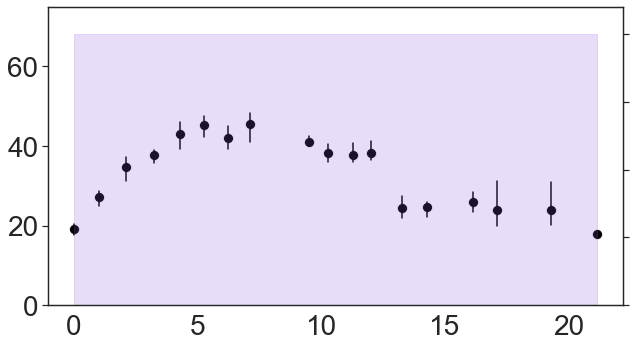

In [7]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(9,5))
# Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = trainingDataDf_avg.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,75)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/data_CT_100uM_%s.pdf"%cellLine)

## b) Calibrate and test a model which assumes PARPi exposure induces cell cycle arrest at the next division (Single Step Model)

In [8]:
# Parameters
modelName = "CycleArrestModel_singleStep"
params = params_growth.copy()
params.add('alpha', value=5e-1, min=0, max=1, vary=True)
params.add('beta', value=0.1, min=0, max=5e-1, vary=True)
params.add('d_A', value=5e-2, min=0, max=4, vary=True)
params.add('P0', value=10, min=0, max=100., vary=False)
params.add('A0', value=0, vary=False)

# Environment
currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)
utils.mkdir(currOutDir);
cycleArrestModelPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                      "P":'g',
                      "A":'purple'}

### Carry out fitting

In [9]:
if runFitting:
    # Setup env
    tmpModel = MakeModelFromStr(modelName)
    currParams = Parameters()
    currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
    if currParams['P0'].vary==False: currParams['P0'].value = trainingDataDf_avg.Confluence.iloc[0]    

    # Fit
    fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
    fitObj.fitId = 0
    fitObj.modelName = modelName
    fitObj.data = trainingDataDf_avg
    fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

    # Post-process
    pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2982e+04                                    2.68e+05    
       1              2         3.0325e+03      9.95e+03       2.81e-01       4.46e+04    
       2              3         1.0695e+03      1.96e+03       5.89e-02       4.13e+03    
       3              5         9.7651e+02      9.30e+01       8.19e-02       1.18e+03    
       4              6         8.8980e+02      8.67e+01       4.49e-02       3.44e+02    
       5              7         7.0596e+02      1.84e+02       8.29e-02       5.44e+02    
       6              8         6.4988e+02      5.61e+01       1.02e-01       2.30e+04    
       7             10         5.9468e+02      5.52e+01       3.48e-02       2.11e+03    
       8             12         5.9382e+02      8.63e-01       1.10e-02       8.27e+02    
       9             13         5.9355e+02      2.76e-01       1.32e-02       9.16e+01    

### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [10]:
if runFitting:
    # Turn off verboseness for bootstrapping
    optimiser_kws_bootstrapping = optimiser_kws.copy()
    optimiser_kws_bootstrapping['verbose'] = 0
    # Run bootstrapping
    perform_bootstrap(fitObj=LoadFit(modelName,fitDir=currOutDir)[0],
                      prior_experiment_df=growthModelBootstrapsDf,
                      n_bootstraps=n_bootstraps, show_progress=True,
                      solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws_bootstrapping, 
                      outName=os.path.join(currOutDir, "bootstraps.csv"))

100%|██████████| 250/250 [08:37<00:00,  2.07s/it]


### Plot fits

In [11]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)

100%|██████████| 250/250 [00:04<00:00, 53.01it/s]


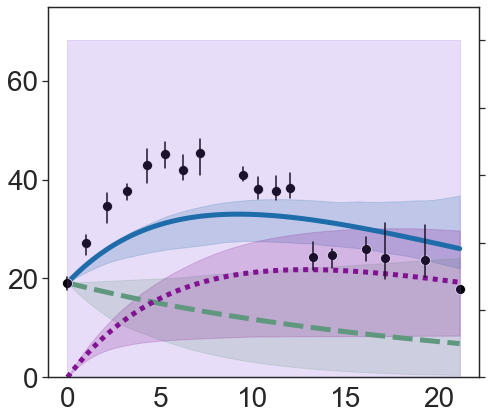

In [12]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=cycleArrestModelPalette,
             legend=False,
             data=modelFitsDf, ax=ax)
for var in cycleArrestModelPalette.keys():
    currDataDf = modelFitsDf[modelFitsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = trainingDataDf_avg.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,75)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/fits_CT_singleStepModel_%s.pdf"%cellLine)

### Test model by benchmarking its ability to predict response to an intermittent schedule

In [13]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(testingDataDf_avg),
                                                     initialConditionsList={"P0":testingDataDf_avg.Confluence.iloc[0], "A0":0},
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)

100%|██████████| 250/250 [00:04<00:00, 50.74it/s]


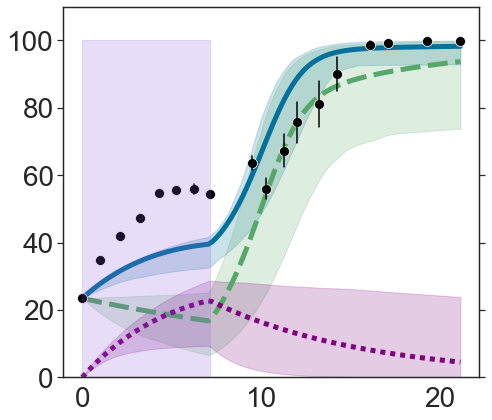

In [14]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=cycleArrestModelPalette,
             legend=False,
             data=modelPredictionsDf, ax=ax)
for var in cycleArrestModelPalette.keys():
    currDataDf = modelPredictionsDf[modelPredictionsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=testingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = testingDataDf_all.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,110)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/predictions_IMT7d_singleStepModel_%s.pdf"%cellLine)

## c) Calibrate and test a model which assumes cells can undergo multiple divisions before being pushed into cell cycle arrest

In [15]:
# Parameters for the multi-step model
modelName = "CycleArrestModel_multiStep"
nStepsList = np.arange(1,5) # Which parameter values for n_steps to examine
params = params_growth.copy()
params.add('alpha', value=0.75, min=0, max=1, vary=True)
params.add('beta', value=0.1, min=0, max=5e-1, vary=True)
params.add('d_A', value=5e-2, min=0, max=4, vary=True)
params.add('n_steps', value=2, min=1, max=5, vary=False)
# Assume that all accumulating damage does not alter the proliferation rate (r) or sensitivity to drug (alpha)
for x in range(params['n_steps'].max):
    params.add('r%d'%x, expr='r', vary=False)
for x in range(params['n_steps'].max):
    params.add('alpha%d'%x, expr='alpha', vary=False)
# Assume that initially all cells are in the P compartment
for x in range(params['n_steps'].max):
    params.add('P%d0'%x, value=0, vary=False)
params.add('A0', value=0, vary=False)

# Environment
currModelOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName+"_equalParams")
utils.mkdir(currModelOutDir);
multiStepPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                    "P0":'#00882B',
                    "P1":'#5C886A',
                    "P2":'#5C796A',
                    "P3":'#5C6E6A',
                    "P4":'#5C626A',
                    "A":'#773F9B'}

### Carry out fitting

In [16]:
if runFitting:
    for n_steps in nStepsList:
        # Setup env
        currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName, n_steps=n_steps)
        currParams = Parameters()
        currParams.add(params['r']) # This allows using the expression syntax in lmfit to fit all the r_i as a single parameter
        currParams.add(params['alpha']) # This allows using the expression syntax in lmfit to fit all the alpha_i as a single parameter
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        if currParams['P00'].vary==False: currParams['P00'].value = trainingDataDf_avg.Confluence.iloc[0]    

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingDataDf_avg
        fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3992e+03                                    5.77e+03    
       1              2         8.2415e+02      5.75e+02       1.42e-01       3.73e+03    
       2              3         7.2460e+02      9.96e+01       2.14e-02       1.55e+03    
       3              5         6.9631e+02      2.83e+01       8.11e-02       2.50e+04    
       4              6         6.1697e+02      7.93e+01       3.28e-02       1.01e+03    
       5              8         6.1207e+02      4.90e+00       9.09e-03       2.38e+02    
       6              9         6.0580e+02      6.26e+00       1.28e-02       9.38e+02    
       7             11         6.0292e+02      2.88e+00       7.78e-03       2.64e+01    
       8             12         5.9764e+02      5.28e+00       1.22e-03       9.56e+00    
       9             13         5.9437e+02      3.27e+00       1.27e-02       1.11e+03    

### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [17]:
if runFitting:
    # Use multi-threading to speed up computation
    pool = mp.Pool(processes=nProcesses)
    def bootstrapJob(job):
        fitObj, n_steps, outName = job
        # Turn off verboseness for bootstrapping
        optimiser_kws_bootstrapping = optimiser_kws.copy()
        optimiser_kws_bootstrapping['verbose'] = 0
        # Refine solver_kws for bootstrapping
        solver_kws_bootstrapping = solver_kws.copy()
        solver_kws_bootstrapping['max_step'] = 0.5
        return perform_bootstrap(fitObj=fitObj,
                          prior_experiment_df=growthModelBootstrapsDf,
                          model_kws={"n_steps":n_steps},
                          n_bootstraps=n_bootstraps, show_progress=False,
                          solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws_bootstrapping, 
                          outName=outName)    
    jobList = []
    for n_steps in nStepsList:
        outDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
        fitObj,_ = LoadFit(modelName,fitDir=outDir)
        jobList.append([fitObj,n_steps,os.path.join(outDir, "bootstraps.csv")])
#     [bootstrapJob(x) for x in jobList]
    list(tqdm(pool.imap(bootstrapJob, jobList), total=len(jobList)));

100%|██████████| 4/4 [10:10<00:00, 152.59s/it]


### Compare goodness-of-fit for different number of hits/steps

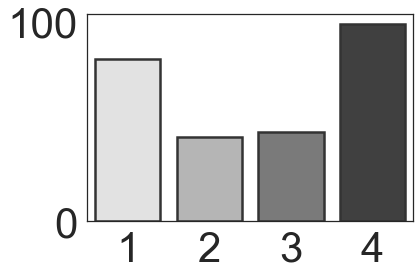

In [18]:
measure = "AIC"
outDir = os.path.join(modelDir,cellLine)
tmpList = []
for n_steps in nStepsList:
    currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(modelName,fitDir=currOutDir)
    tmpList.append({"n_steps":n_steps, "FitId":fitObj.fitId,
                    "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
comparisonDf_gof = pd.DataFrame(tmpList)

# Plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
comparisonDf_gof.sort_values(by=measure,inplace=True)
sns.barplot(x="n_steps",y=measure,
            edgecolor=".2",linewidth=2.5,
            palette="Greys",
            data=comparisonDf_gof, ax=ax)
ax.tick_params(labelsize=42)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.set_xticks([])
plt.tight_layout()
plt.savefig("./figures/%s_different_n_steps_equalParams_%s.pdf"%(measure,cellLine))

### Plot fit for #Hits=2

100%|██████████| 250/250 [00:03<00:00, 78.92it/s]


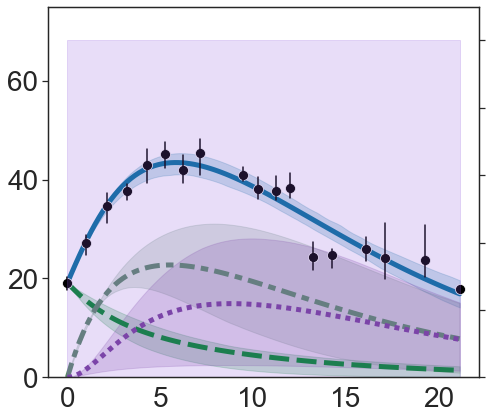

In [19]:
# Load models and simulate
n_steps = 2
currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                     model_kws={"n_steps":n_steps},
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws, optimiser_kws=optimiser_kws)

# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=multiStepPalette,
             style_order=["TumourSize","P0","A","P1"],
             legend=False,
             data=modelFitsDf, ax=ax)
for var in multiStepPalette.keys():
    currDataDf = modelFitsDf[modelFitsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=multiStepPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = trainingDataDf_avg.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,75)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/fits_CT_multiStepModel_%s.pdf"%cellLine)

In [20]:
for n_steps in [2,3]:
    currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
    fitObj,_ = LoadFit(modelName,fitDir=currOutDir)
    print("n Hits: %d, r2=%1.2f"%(n_steps,fitObj.rSq))

n Hits: 2, r2=0.91
n Hits: 3, r2=0.90


### Test model by benchmarking its ability to predict response to an intermittent schedule

In [21]:
# Load models and simulate
n_steps = 2
currOutDir = os.path.join(currModelOutDir,"n_steps_%d"%(n_steps))
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(testingDataDf_avg),
                                                     model_kws={"n_steps":n_steps},                                                           
                                                     initialConditionsList={"P00":testingDataDf_avg.Confluence.iloc[0], "P10":0, "A0":0},
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)

100%|██████████| 250/250 [00:06<00:00, 40.32it/s]


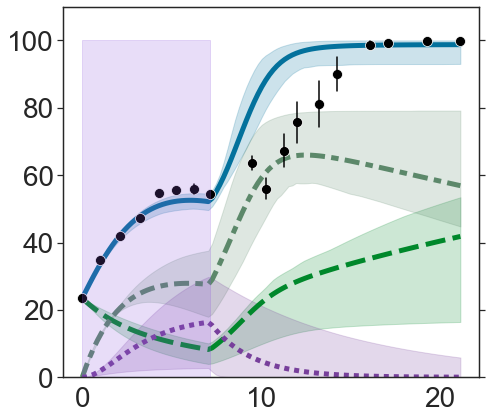

In [22]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=multiStepPalette,
             style_order=["TumourSize","P0","A","P1"],
             legend=False,
             data=modelPredictionsDf, ax=ax)
for var in multiStepPalette.keys():
    currDataDf = modelPredictionsDf[modelPredictionsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=multiStepPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=testingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = testingDataDf_all.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,110)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/predictions_IMT7d_multiStepModel_%s.pdf"%cellLine)

## d) Calibrate and test a model which assumes cells can undergo further divisions after PARPi-induced damage but are eventually all pushed into cell cycle arrest

In [23]:
# Parameters
modelName = "CycleArrestModel_singleStep_extraDivs"
params = params_growth.copy()
params.add('alpha', value=5e-1, min=0, max=1, vary=True)
params.add('phi', value=5e-1, min=0, max=2, vary=True)
params.add('d_A', value=5e-2, min=0, max=4, vary=True)
params.add('P0', value=10, min=0, max=100., vary=False)
params.add('A0', value=0, vary=False)

# Environment
currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)
utils.mkdir(currOutDir);
cycleArrestModelPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                      "P":'g',
                      "A":'purple'}

### Carry out fitting

In [24]:
if runFitting:
    # Setup env
    tmpModel = MakeModelFromStr(modelName)
    currParams = Parameters()
    currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
    if currParams['P0'].vary==False: currParams['P0'].value = trainingDataDf_avg.Confluence.iloc[0]    

    # Fit
    fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
    fitObj.fitId = 0
    fitObj.modelName = modelName
    fitObj.data = trainingDataDf_avg
    fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

    # Post-process
    pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.0023e+03                                    4.12e+05    
       1              2         1.1112e+03      7.89e+03       1.49e-01       4.58e+04    
       2              3         2.9311e+02      8.18e+02       1.02e-01       4.24e+03    
       3              4         8.8056e+01      2.05e+02       6.85e-01       3.33e+02    
       4              5         8.7105e+01      9.51e-01       1.06e-01       1.14e+04    
       5              6         7.1938e+01      1.52e+01       3.48e-02       2.43e+02    
       6              8         7.1627e+01      3.11e-01       1.16e-02       4.44e+02    
       7             10         7.1505e+01      1.22e-01       5.64e-03       9.21e+01    
       8             11         7.1401e+01      1.04e-01       1.11e-02       4.40e+02    
       9             13         7.1337e+01      6.38e-02       5.37e-03       9.30e+01    

### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [25]:
if runFitting:
    # Turn off verboseness for bootstrapping
    optimiser_kws_bootstrapping = optimiser_kws.copy()
    optimiser_kws_bootstrapping['verbose'] = 0
    # Run bootstrapping
    growthModelBootstrapsDf = pd.read_csv(os.path.join(modelDir, "growthModel", cellLine, growthModel, "bootstraps.csv"), index_col=0)
    perform_bootstrap(fitObj=LoadFit(modelName,fitDir=currOutDir)[0],
                      prior_experiment_df=growthModelBootstrapsDf,
                      n_bootstraps=n_bootstraps, show_progress=True,
                      solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws_bootstrapping, 
                      outName=os.path.join(currOutDir, "bootstraps.csv"))

100%|██████████| 250/250 [04:59<00:00,  1.20s/it]


### Plot fits

In [26]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)

100%|██████████| 250/250 [00:04<00:00, 52.57it/s]


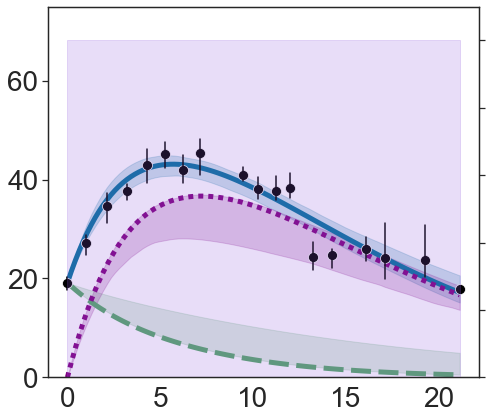

In [27]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=cycleArrestModelPalette,
             legend=False,
             data=modelFitsDf, ax=ax)
for var in cycleArrestModelPalette.keys():
    currDataDf = modelFitsDf[modelFitsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = trainingDataDf_avg.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,75)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/fits_CT_fractionalModel_%s.pdf"%cellLine)

### Test model by benchmarking its ability to predict response to an intermittent schedule

In [28]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(testingDataDf_avg),
                                                     initialConditionsList={"P0":testingDataDf_avg.Confluence.iloc[0], "A0":0},
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)

100%|██████████| 250/250 [00:05<00:00, 49.85it/s]


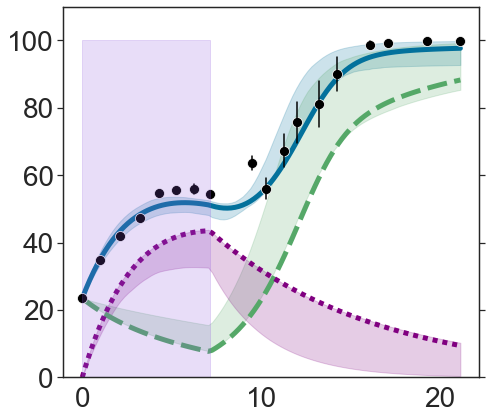

In [29]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=cycleArrestModelPalette,
             legend=False,
             data=modelPredictionsDf, ax=ax)
for var in cycleArrestModelPalette.keys():
    currDataDf = modelPredictionsDf[modelPredictionsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=testingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = testingDataDf_all.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,110)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/predictions_IMT7d_fractionalModel_%s.pdf"%cellLine)